# Automatic differentiation lab work

*Notebook prepared by Mathieu Blondel, November 2020.
The accompanying slides are available [here](https://www.mblondel.org/teaching/autodiff-2020.pdf).*

In this lab work, we are going to implement reverse differentiation (a.k.a. backpropagation) for a feedforward network (that is, the composition of a **sequence** or **chain** of functions).

## Numerical differentiation utilities

In this section, I define utility functions for computing Jacobians, Jacobian-vector products (VJPs), and vector Jacobian products (VJPs). You will need to use them to check the correctness of your implementations.

In [1]:
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split

def num_jvp(f, x, v, eps=1e-6):
    """
    Args:
    f: a function returning an array.
    x: an array.
    v: an array (same shape as x).

    Returns:
    numerical_jvp
    """
    if not np.array_equal(x.shape, v.shape):
        raise ValueError("x and v should have the same shape.")

    return (f(x + eps * v) - f(x - eps * v)) / (2 * eps)

def num_jacobian(f, x, eps=1e-6):
    """
    Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

    Returns:
    numerical_jacobian
    """
    def e(i):
        ret = np.zeros_like(x)
        ret[i] = 1
        return ret

    def E(i, j):
        ret = np.zeros_like(x)
        ret[i, j] = 1
        return ret

    if len(x.shape) == 1:
        return np.array([num_jvp(f, x, e(i), eps=eps) for i in range(len(x))]).T
    elif len(x.shape) == 2:
        return np.array([[num_jvp(f, x, E(i, j), eps=eps) \
                     for i in range(x.shape[0])] \
                     for j in range(x.shape[1])]).T
    else:
        raise NotImplementedError

def num_vjp(f, x, u, eps=1e-6):
    """
    Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

    Returns:
    numerical_vjp
    """
    J = num_jacobian(f, x, eps=eps)
    if len(J.shape) == 2:
        return J.T.dot(u)
    elif len(J.shape) == 3:
        shape = J.shape[1:]
        J = J.reshape(J.shape[0], -1)
        return u.dot(J).reshape(shape)
    else:
        raise NotImplementedError


## Vector Jacobian products (VJPs) for basic primitives

In this section, we are going to define VJPs for basic primitives. 

In [2]:
def dot(x, W):
    return np.dot(W, x)

def dot_make_vjp(x, W):
    def vjp(u):
        return W.T.dot(u), np.outer(u, x)
    return vjp

dot.make_vjp = dot_make_vjp

def squared_loss(y_pred, y):
    # The code requires every output to be an array.
    return np.array([0.5 * np.sum((y - y_pred) ** 2)])

def squared_loss_make_vjp(y_pred, y):
    diff = y_pred - y

    def vjp(u):
        return u * diff, - u * diff

    return vjp

squared_loss.make_vjp = squared_loss_make_vjp


def bce_loss(y_pred, y, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    return np.clip(-np.array((y * np.log(y_pred) + (1-y) * np.log(1-y_pred))), clip, 1-clip)


def bce_loss_make_vjp(y_pred, y, threshold=1, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    diff_pred =  (1-y) / (1-y_pred) - y / y_pred
#     norm_pred = np.linalg.norm(diff_pred)
# #     print('norm_predd', norm_pred)
#     if norm_pred > threshold:
#         diff_pred /= norm_pred
    
    diff_param = np.log(1 - y_pred) - np.log(y_pred)
#     norm_param = np.linalg.norm(diff_param)
# #     print('norm param', norm_param)
#     if norm_param > threshold:
#         diff_param /= norm_param
        
    def vjp(u):
        return u * diff_pred, u * diff_param

    return vjp

bce_loss.make_vjp = bce_loss_make_vjp


def cat_cross_entropy_loss(y_pred, y, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    l = np.sum(y * np.log(y_pred))
    return - np.array([l])

def cat_cross_entropy_loss_make_vjp(y_pred, y, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    diff_pred = - y / y_pred
    diff_param = - np.log(y_pred)
    
    def vjp(u):
        return u * diff_pred, u * diff_param
    
    return vjp

cat_cross_entropy_loss.make_vjp = cat_cross_entropy_loss_make_vjp



# def cat_cross_entropy(preds, labels):
#     return - np.sum(labels * np.log(preds))


# def d_cat_cross_entropy(preds, labels, clipping=None):
#     grad = - labels / preds
#     norm = np.linalg.norm(grad)
#     if clipping and norm > clipping:
#         grad = clipping * grad / norm
#     return grad

def add(a, b):
    return a + b

def add_make_vjp(a, b):
    gprime = np.ones(len(a))

    def vjp(u):
        return u * gprime, u * gprime

    return vjp

add.make_vjp = add_make_vjp

def mul(a, b):
    return a * b

def mul_make_vjp(a, b):
    gprime_a = b
    gprime_b = a

    def vjp(u):
        return u * gprime_a, u * gprime_b

    return vjp

mul.make_vjp = mul_make_vjp

def exp(x, clip=700):
    x = np.clip(x, -clip, clip)
    return np.exp(x)

def exp_make_vjp(x):
    gprime = exp(x)

    def vjp(u):
        return u * gprime,

    return vjp

exp.make_vjp = exp_make_vjp

def sqrt(x):
    return np.sqrt(x)

def sqrt_make_vjp(x):
    gprime = 1. / (2 * sqrt(x))

    def vjp(u):
        return u * gprime,

    return vjp

sqrt.make_vjp = sqrt_make_vjp

In [63]:
x = cat_cross_entropy_loss(np.array([0.8, 0.1, 0.1]), np.array([1, 0, 0]))
x

array([0.22314355])

**Exercise 1** 

Look at the "exp" and "sqrt"  examples above and define the primitive and its associated VJP for the relu function `relu(x) = np.maximum(x, 0)`. Check the correctness of your implementation using the `num_vjp` utility function.

In [3]:
def relu(x):
     return np.where(x > 0, x, 0)
    
def relu_make_vjp(x):
    gprime = np.where(x > 0, 1, 0)
    
    def vjp(u):
        return u * gprime,
    return vjp

relu.make_vjp = relu_make_vjp


def sigmoid(x, over_clip=700, under_clip=-700):
    x = np.clip(x, under_clip, over_clip)
    return 1 / (1 + np.exp(-x))


def sigmoid_make_vjp(x, over_clip=700, under_clip=-700):
    x = np.clip(x, under_clip, over_clip)
    y = np.exp(-x)
    gprime = y / (1 + y)**2
    
    def vjp(u):
        return u * gprime,
    return vjp

sigmoid.make_vjp = sigmoid_make_vjp


def tanh(x, over_clip=700, under_clip=-700):
    x = np.clip(2 * x, under_clip, over_clip)
    y = np.exp(-x)
    return (1-y)/(1+y)

def tanh_make_vjp(x):
    gprime = 1 - tanh(x)**2
    
    def vjp(u):
        return u * gprime,
    return vjp

tanh.make_vjp = tanh_make_vjp
    


def d_tanh(x):
    y = tanh(x)
#     print(y.shape)
#     print('diag', np.diag(y).shape)
    return np.diag(1 - y**2)


def softmax(x, over_clip=700, under_clip=-700):
    x = np.clip(x, under_clip, over_clip)
    y = np.exp(x)
    return y / np.sum(y)

def softmax_make_vjp(x):
    y = softmax(x)
    d = np.diag(y)
    y = np.expand_dims(y, axis=1)
    gprime = d - y @ y.T
    
    def vjp(u):
        return gprime @ u,
    return vjp

softmax.make_vjp = softmax_make_vjp

# Check the correctness of your vjp using num_vjp:
# num_vjp(relu.make_vjp, x, u)

## Reverse differentiation of feedforward networks

Feedforward networks use a sequence of functions. The functions can either be of the form `func(x, param)` if the function has learnable parameters (e.g., `dot(x, W)`) or `func(x)` if the function doesn't have learnable parameters (e.g., `exp(x)`). 

We represent a feedforward network using a list of functions and a list of parameters. Let us create a small utility function for creating such a network.

In [4]:
def call_func(x, func, param):
    """Make sure the function is called with the correct number of arguments."""

    if param is None:
        # Unary function
        return func(x)
    else:
        # Binary function
        return func(x, param)
    
    
def call_vjp(x, func, param, u):
    """Make sure the vjp is called with the correct number of arguments."""
    if param is None:
        vjp = func.make_vjp(x)
        vjp_x, = vjp(u)
        vjp_param = None
    else:
        vjp = func.make_vjp(x, param)
        vjp_x, vjp_param = vjp(u)
    return vjp_x, vjp_param

In [5]:
class FeedForwardNetwork():
    def __init__(self, loss, input_shape, shapes, activation_functions, use_biases):
        self.loss = loss
        self.input_shape = input_shape
        self.shapes = shapes
        self.activation_functions = activation_functions
        self.use_biases = use_biases
        self.funcs, self.params = self.create_feed_forward(
            self.loss, self.input_shape, self.shapes, self.activation_functions, self.use_biases
        )
        
    def make_layer(self, in_shape, out_shape, use_bias=False):
        W = np.random.randn(out_shape, in_shape).astype(np.float64)
        if use_bias:
            b = np.zeros(out_shape).astype(np.float64)
            return W, b
        else:
            return W, None

    def create_feed_forward(self, loss, input_shape, shapes, activation_functions, use_biases):
        params, funcs = list(), list()
        current_shape = input_shape
        for i in range(len(activation_functions)):
            W, b = self.make_layer(current_shape, shapes[i], use_biases[i])
            params.append(W)
            funcs.append(dot)
            if b is not None:
                params.append(b)
                funcs.append(add)
            params.append(None)
            funcs.append(activation_functions[i])
            current_shape = shapes[i]

        # append fake loss input to make sure that params and funcs have the same length
        params.append(1.0)
        funcs.append(loss)

        return funcs, params
    
    def __call__(self, x, return_loss=False, return_all=False):
        """
        Evaluate a chain of functions.

        Args:
        x: initial input to the chain.
        funcs: a list of functions of the form func(x) or func(x, param).
        params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.
        return_all: whether to return all intermediate values or only the last one.
        return_loss: wether to return loss or model output

        Returns:
        value (return_all == False) or values (return_all=True)
        """
        if len(self.funcs) != len(self.params):
            raise ValueError("len(funcs) and len(params) should be equal.")
        if return_loss:
            K = len(self.funcs)
        else:
            K = len(self.funcs) - 1
        if return_all:
            X = list()
            X.append(x)
            for k in range(K):
                x = call_func(x, self.funcs[k], self.params[k])
                X.append(x)
            return X
        else:
            for k in range(K):
                x = call_func(x, self.funcs[k], self.params[k])
            return x
        
    def backward(self, x, y_truth):
        """
        Reverse-mode differentiation of a chain of computations.

        Args:
        x: initial input to the chain.
        funcs: a list of functions of the form func(x) or func(x, param).
        params: a list of parameters, with len(params) = len(funcs).
                If a function doesn't have parameters, use None.

        Returns:
        value, Jacobian w.r.t. x
        """
        # Evaluate the feedforward model and store intermediate computations,
        # as they will be needed during the backward pass.
        self.params[-1] = y_truth
        xs = self.__call__(x, return_loss=True, return_all=True)
        
        m = xs[-1].shape[0]  # Output size
        K = len(self.funcs)  # Number of functions.

        # We need a list as the shape of U can change.
        U = list(np.eye(m))
        jac_params = list()

        for k in reversed(range(K)):
            V = [call_vjp(xs[k], self.funcs[k], self.params[k], u) for u in U]

            # update weights or biases auto_diff
            if self.params[k] is not None:
                jac_params.insert(0, np.asarray([v[1] for v in V])[0])
            else:
                jac_params.insert(0, None)

            # update activation function auto_diff
            U = [v[0] for v in V]

        return xs, np.array(U), jac_params
    
    def update_params(self, jac_params, lr):
        self.params = [p - lr * jp if (p is not None and jp is not None) else None for p, jp in zip(self.params, jac_params)]

        


# y = 1.5
# n = 28*28
# o_shape = 3
# shapes = [64, 32, o_shape]
# # shapes = [64, 32, 1]
# activation_functions = [tanh, tanh, softmax]
# use_biases = [True, True, True]

# model = FeedForwardNetwork(cat_cross_entropy_loss, n, shapes, activation_functions, use_biases)
# # model(np.random.randn(2), return_all=True)

# batch_size = 32

# for i in range(20000):
#     if random.random() < 0.33:
#         x = (np.random.randn(n) + 10 * np.ones(n)) / 10
#         label = np.array([1, 0, 0])
#     elif random.random() < 0.66:
#         x = (np.random.randn(n) - 10 * np.ones(n)) / 10
#         label = np.array([0, 1, 0])
#     else:
#         x = np.random.randn(n) / 10
#         label = np.array([0, 0, 1])
#     Y, _, J = model.backward(x, label)
#     model.update_params(J, 0.01)
#     print('l', Y[-1])
#     print(Y[-2], label)
#     print()


In [68]:
for i in range(30):
    if random.random() < 0.33:
        x = (np.random.randn(n) + 10 * np.ones(n)) / 10
        label = np.array([1, 0, 0])
    elif random.random() < 0.66:
        x = (np.random.randn(n) - 10 * np.ones(n)) / 10
        label = np.array([0, 1, 0])
    else:
        x = np.random.randn(n) / 10
        label = np.array([0, 0, 1])
    print(model(x), label)

[5.93875409e-09 9.96109889e-01 3.89010477e-03] [0 1 0]
[9.95787012e-01 1.19181510e-08 4.21297605e-03] [1 0 0]
[9.95785821e-01 1.19210267e-08 4.21416719e-03] [1 0 0]
[9.95784880e-01 1.19240829e-08 4.21510790e-03] [1 0 0]
[5.93876191e-09 9.96109849e-01 3.89014496e-03] [0 1 0]
[9.95787525e-01 1.19188237e-08 4.21246317e-03] [1 0 0]
[2.76804899e-05 1.42666598e-03 9.98545654e-01] [0 0 1]
[9.95784799e-01 1.19241410e-08 4.21518920e-03] [1 0 0]
[5.93881393e-09 9.96109908e-01 3.89008603e-03] [0 1 0]
[9.95784882e-01 1.19240914e-08 4.21510584e-03] [1 0 0]
[5.93473334e-09 9.96112183e-01 3.88781153e-03] [0 1 0]
[5.93456327e-09 9.96104024e-01 3.89596996e-03] [0 1 0]
[9.95784893e-01 1.19240586e-08 4.21509553e-03] [1 0 0]
[1.69452849e-05 8.06043384e-05 9.99902450e-01] [0 0 1]
[5.93691338e-09 9.96111419e-01 3.88857496e-03] [0 1 0]
[5.93871371e-09 9.96109879e-01 3.89011465e-03] [0 1 0]
[5.93875802e-09 9.96109854e-01 3.89014018e-03] [0 1 0]
[5.93875772e-09 9.96109830e-01 3.89016417e-03] [0 1 0]
[2.1416645

In [6]:
data = pd.read_csv('/home/data_scientist/dataIASD/fashion_lnist/fashion-mnist_train.csv')
train, val = train_test_split(data, test_size=0.2)

In [7]:
train_images, train_labels = (np.array(train)[:, 1:] / 255.).astype(np.float64), np.array(train)[:, 0]
val_images, val_labels = (np.array(val)[:, 1:] / 255.).astype(np.float64), np.array(val)[:, 0]

def fashion_mnist_generator(images, labels, batch_size):
    indices = np.random.permutation(len(labels))
    for i in range(0, len(indices), batch_size):
        current_indices = indices[i:i+batch_size]
        current_images, current_labels = images[current_indices, :], to_categorical(labels[current_indices])
#         current_labels = [to_categorical(l) for l in labels[current_indices]]
        yield current_images, current_labels
        
        
def to_categorical(labels, num_classes=10):
    categorical_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        categorical_labels[i, labels[i]] = 1
    return categorical_labels
    

for img, label in fashion_mnist_generator(train_images, train_labels, 32):
    print(img.shape, label)

(32, 784) [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


(32, 784) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


(32, 784) [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


(32, 784) [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


(32, 784) [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


(32, 784) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


(32, 784) [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


(32, 784) [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


KeyboardInterrupt: 

In [8]:
n = 28*28
o_shape = 10
shapes = [64, 128, 32, o_shape]
# shapes = [64, 32, 1]
activation_functions = [tanh, tanh, tanh, softmax]
use_biases = [True, True, True, True]

fashion_model = FeedForwardNetwork(cat_cross_entropy_loss, n, shapes, activation_functions, use_biases)
# model(np.random.randn(2), return_all=True)

batch_size = 64
lr = 0.01
num_epochs = 15
plot_frequency = 10

axis = list()
loss_values = list()

for e in range(num_epochs):
    for i, (imgs, labels) in enumerate(fashion_mnist_generator(train_images, train_labels, batch_size)):
    #     print(i)
        auto_diffs = [fashion_model.backward(x, y) for x, y in zip(imgs, labels)]
    #     print(auto_diffs[0][2])
    #     print()
    #     print()
    #     [model.update_params(a[2], lr) for a in auto_diffs]
        for a in auto_diffs:
    #         print(a[2])
            fashion_model.update_params(a[2], lr)
        if i % plot_frequency == 0:
            axis.append(i * batch_size + len(train_labels) * e)
            loss_values.append(np.average([a[0][-1] for a in auto_diffs]))
            print('Epoch {}, {:2f}%, loss = {:2f}'.format(e, i * batch_size * 100 / len(train_labels), np.average([a[0][-1] for a in auto_diffs])))

Epoch 0, 0.000000%, loss = 6.270777
Epoch 0, 1.333333%, loss = 2.290770
Epoch 0, 2.666667%, loss = 3.099409
Epoch 0, 4.000000%, loss = 2.529710
Epoch 0, 5.333333%, loss = 1.747271
Epoch 0, 6.666667%, loss = 2.010328
Epoch 0, 8.000000%, loss = 1.890391
Epoch 0, 9.333333%, loss = 2.130313
Epoch 0, 10.666667%, loss = 1.510930
Epoch 0, 12.000000%, loss = 1.276887
Epoch 0, 13.333333%, loss = 1.363965
Epoch 0, 14.666667%, loss = 1.744669
Epoch 0, 16.000000%, loss = 1.878289
Epoch 0, 17.333333%, loss = 1.537047
Epoch 0, 18.666667%, loss = 1.347012
Epoch 0, 20.000000%, loss = 1.656213
Epoch 0, 21.333333%, loss = 1.316914
Epoch 0, 22.666667%, loss = 1.776527
Epoch 0, 24.000000%, loss = 1.386680
Epoch 0, 25.333333%, loss = 1.966180
Epoch 0, 26.666667%, loss = 1.169889
Epoch 0, 28.000000%, loss = 1.488588
Epoch 0, 29.333333%, loss = 1.272522
Epoch 0, 30.666667%, loss = 1.265968
Epoch 0, 32.000000%, loss = 1.148085


KeyboardInterrupt: 

In [9]:
acc = 0.0
for i, (imgs, labels) in enumerate(fashion_mnist_generator(val_images, val_labels, batch_size)):
    preds = [fashion_model(x) for x in imgs]
    acc += np.count_nonzero([np.argmax(p) == np.argmax(l) for p, l in zip(preds, labels)])
    if i % 10 == 1:
        current_acc = acc
        print(i, current_acc / (i * batch_size))

1 1.203125
11 0.6448863636363636
21 0.6004464285714286
31 0.5907258064516129
41 0.586890243902439
51 0.5808823529411765
61 0.5755635245901639
71 0.5695422535211268
81 0.5630787037037037
91 0.5597527472527473
101 0.5611076732673267
111 0.5605292792792793
121 0.5608212809917356
131 0.5603530534351145
141 0.5603945035460993
151 0.5612582781456954
161 0.5602678571428571
171 0.5629568713450293
181 0.5633632596685083


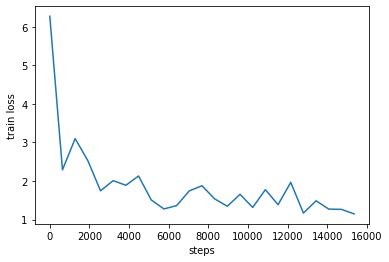

In [10]:
import matplotlib.pyplot as plt

plt.plot(axis, loss_values)
plt.ylabel('train loss')
plt.xlabel('steps')
plt.show()

In [43]:
def small_gaussian_generator(n_iter, n, batch_size):
    for _ in range(n_iter):
        labels = np.random.randint(0, 2, batch_size)
        values = [np.random.randn(n) + 5 * ((-1)**l) * np.ones(n) for l in labels]
        yield values, labels

input_space = 28*28
shapes = [64, 16, 1]
activation_functions = [tanh, tanh, sigmoid]
use_biases = [True, True, True]
test_model = FeedForwardNetwork(bce_loss, input_space, shapes, activation_functions, use_biases)
# model(np.random.randn(2), return_all=True)

batch_size = 32

# x = np.random.randn(2)
# x, _, J = model.backward(x, 1)
# model.update_params(J, 0.01)

lr = 0.1
np.seterr(divide = 'raise', invalid='raise', over='raise', under='raise') 

for i, (imgs, labels) in enumerate(small_gaussian_generator(20000, input_space, batch_size)):
#     print(i)
    auto_diffs = [test_model.backward(x, y) for x, y in zip(imgs, labels)]
#     print(auto_diffs[0][2])
#     print()
#     print()
#     [model.update_params(a[2], lr) for a in auto_diffs]
    for a in auto_diffs:
#         print(a[2])
        test_model.update_params(a[2], lr)
    if i % 5 == 0:
        print(i * 100 / 20000, np.average([a[0][-1] for a in auto_diffs]))

0.0 0.2557937763248862
0.025 6.11401464701633e-06
0.05 4.788074660688617e-06
0.075 4.531071885653671e-06
0.1 5.4520071446602445e-06
0.125 6.9853007509994474e-06
0.15 5.7594798680563005e-06
0.175 5.031976163788248e-06
0.2 8.186656330879953e-06
0.225 4.636950216169e-06
0.25 5.8051906472204306e-06
0.275 9.100840443634128e-06
0.3 3.4242464771268166e-06
0.325 5.069323889545602e-06
0.35 6.3861093717238015e-06
0.375 4.730008023206076e-06
0.4 6.202025125785481e-06
0.425 5.312870077074788e-06
0.45 3.83961221804734e-06
0.475 6.698722352285649e-06
0.5 6.010784117688419e-06
0.525 4.377290886140637e-06
0.55 4.1314887621071106e-06
0.575 4.347550947538806e-06
0.6 4.0571959893260785e-06
0.625 4.552876007747973e-06
0.65 4.688896750409916e-06
0.675 5.283566410231414e-06
0.7 3.6970246051684187e-06
0.725 4.374850783157924e-06
0.75 4.317601628102298e-06
0.775 4.325895648336001e-06
0.8 4.579272341087545e-06
0.825 5.03922928407203e-06
0.85 4.391542131335971e-06
0.875 9.04816684697428e-06
0.9 4.65983080852482

KeyboardInterrupt: 

In [44]:
for img, label in small_gaussian_generator(40, input_space, 1):
    y = test_model(img[0])
    print(y, label)

[2.86147524e-06] [0]
[2.98530497e-06] [0]
[0.99998967] [1]
[0.99999535] [1]
[2.98530498e-06] [0]
[0.99999633] [1]
[0.99999508] [1]
[3.60223859e-05] [0]
[0.99999633] [1]
[0.99999491] [1]
[2.66406049e-06] [0]
[0.99999633] [1]
[2.07598736e-06] [0]
[2.45601141e-06] [0]
[2.04534784e-06] [0]
[2.68369231e-06] [0]
[2.3827635e-06] [0]
[0.99999633] [1]
[0.99999696] [1]
[0.99995335] [1]
[4.03404428e-06] [0]
[7.5264563e-06] [0]
[5.33915956e-06] [0]
[0.999993] [1]
[4.18811851e-06] [0]
[0.99999781] [1]
[0.99999392] [1]
[0.99994724] [1]
[0.99999633] [1]
[2.07439968e-06] [0]
[0.99999488] [1]
[2.04486569e-06] [0]
[2.09035753e-06] [0]
[2.98530477e-06] [0]
[0.99998801] [1]
[0.9999948] [1]
[2.86145706e-06] [0]
[0.99999733] [1]
[0.99999278] [1]
[2.78425612e-06] [0]


In [ ]:
x = -832
clip = 300
x = np.clip(x, -clip, clip)
y = np.exp(-x)
d = (1 + y)**2
gprime = y / d
gprime

Next, let us create a small utility function for correctly calling each function, depending on whether it has 1 or 2 arguments.

**Exercise 2.** 

Implement the following function for evaluating the feedforward network. Check that the returned value is correct.

In [ ]:
def evaluate_chain(x, funcs, params, return_all=False):
    """
    Evaluate a chain of functions.

    Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.
    return_all: whether to return all intermediate values or only the last one.

    Returns:
    value (return_all == False) or values (return_all=True)
    """
    if len(funcs) != len(params):
        raise ValueError("len(funcs) and len(params) should be equal.")

    if return_all:
        X = list()
        X.append(x)
        for f, param in zip(funcs, params):
            x = call_func(x, f, param)
            X.append(x)
        return X
    else:
        for f, param in zip(funcs, params):
            x = call_func(x, f, param)
        return x

rng = np.random.RandomState(0)
x = rng.randn(2)
y = 1.5

shapes = [4, 8, 1]
activation_functions = [relu, relu, sigmoid]
use_biases = [True, True, True]

funcs, params = create_feed_forward(y, bce_loss, 2, shapes, activation_functions, use_biases)
# W1, _, W3, _, W5, y = params

# # Make sure that `evaluate_chain(x, funcs, params)` returns the same value as
# # a manual implementaton:
# x1 = dot(x, W1)
# x2 = relu(x1)
# x3 = dot(x2, W3)
# x4 = relu(x3)
# x5 = dot(x4, W5)
# value = squared_loss(x5, y)
print(value)
out = evaluate_chain(x, funcs, params)
print(out)
print(funcs, params)

**Exercise 3.**

Reusing the previous function with `return_all=True`, implement the following function that returns both the network value and the Jacobian w.r.t. `x`. Check correctness of the Jacobian using `num_jacobian`.

In [ ]:
def call_vjp(x, func, param, u):
    """Make sure the vjp is called with the correct number of arguments."""
    if param is None:
        vjp = func.make_vjp(x)
        vjp_x, = vjp(u)
        vjp_param = None
    else:
        vjp = func.make_vjp(x, param)
        vjp_x, vjp_param = vjp(u)
    return vjp_x, vjp_param


def reverse_diff_chain(x, funcs, params):
    """
    Reverse-mode differentiation of a chain of computations.

    Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.

    Returns:
    value, Jacobian w.r.t. x
    """
    # Evaluate the feedforward model and store intermediate computations,
    # as they will be needed during the backward pass.
    xs = evaluate_chain(x, funcs, params, return_all=True)

    m = xs[-1].shape[0]  # Output size
    K = len(funcs)  # Number of functions.

    # We need a list as the shape of U can change.
    U = list(np.eye(m))
    jac_params = list()

    for k in reversed(range(K)):
        V = [call_vjp(xs[k], funcs[k], params[k], u) for u in U]
        
        # update weights or biases auto_diff
        if params[k] is not None:
            jac_params.insert(0, np.asarray([v[1] for v in V])[0])
        
        # update activation function auto_diff
        U = [v[0] for v in V]

    return xs[-1], np.array(U), jac_params

# Check correctness of Jacobian using `num_jacobian`.
def f(x):
    return evaluate_chain(x, funcs, params)
# num_jacobian only accepts functions of one argument.
num_jac = num_jacobian(f, x)
value, jac, jac_params = reverse_diff_chain(x, funcs, params)

print(x)
print(num_jac)
print(jac)

true_params = [p for p in params if p is not None]
print(len(true_params), len(jac_params))
for k in range(len(true_params)):
    print(k)
    print(type(true_params[k]), type(jac_params[k]))
    print(jac_params[k].shape)


# def f2(params):
#     return evaluate_chain(x, funcs, params)

# num_jac

**Bonus exercise.**

Modify the above function to also return the Jacobians w.r.t. W1, W3, W5. Check correctness using `num_jacobian`.